In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers

Using TensorFlow backend.


### Autoencoders: Alternatives

1) The hidden representations are only constrained by the size of the hidden layer. In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). 

2) The hidden representation is sparse (L1 regularization)

3) The hidden representation is deep (several hidden layers)

##### In this notebook, we'll explore the first and second alternatives.

In [14]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
num_epochs = 50
sparse = False
activity_regularizer = regularizers.l1(10e-5) if sparse == True else None


In [4]:
# this is our input placeholder
input_img = Input(shape=(784,))
input_img

<tf.Tensor 'input_1:0' shape=(?, 784) dtype=float32>

In [5]:
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=activity_regularizer)(input_img)
encoded

<tf.Tensor 'dense_1/Relu:0' shape=(?, 32) dtype=float32>

In [6]:
decoded = Dense(784, activation='sigmoid')(encoded)
decoded

<tf.Tensor 'dense_2/Sigmoid:0' shape=(?, 784) dtype=float32>

In [7]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Let's also create a separate encoder model:

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [9]:
# as well as the decoder model:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [11]:
(x_train, _), (x_test, _) = mnist.load_data(path = './mnist.npz')
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [12]:
#We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [15]:
autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s - loss: 0.1955 - val_loss: 0.1894
Epoch 2/50
60000/60000 [==============================] - 3s - loss: 0.1870 - val_loss: 0.1819
Epoch 3/50
60000/60000 [==============================] - 4s - loss: 0.1803 - val_loss: 0.1759
Epoch 4/50
60000/60000 [==============================] - 4s - loss: 0.1747 - val_loss: 0.1707
Epoch 5/50
60000/60000 [==============================] - 3s - loss: 0.1697 - val_loss: 0.1660
Epoch 6/50
60000/60000 [==============================] - 4s - loss: 0.1652 - val_loss: 0.1617
Epoch 7/50
60000/60000 [==============================] - 3s - loss: 0.1611 - val_loss: 0.1577
Epoch 8/50
60000/60000 [==============================] - 4s - loss: 0.1572 - val_loss: 0.1539
Epoch 9/50
60000/60000 [==============================] - 4s - loss: 0.1536 - val_loss: 0.1505
Epoch 10/50
60000/60000 [==============================] - 4s - loss: 0.1503 - val_loss: 0.1473

In [16]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
encoded_imgs.shape

(10000, 32)

In [17]:
# how sparse are the encodings
encoded_imgs.mean()

7.5849142

In [18]:
decoded_imgs = decoder.predict(encoded_imgs)


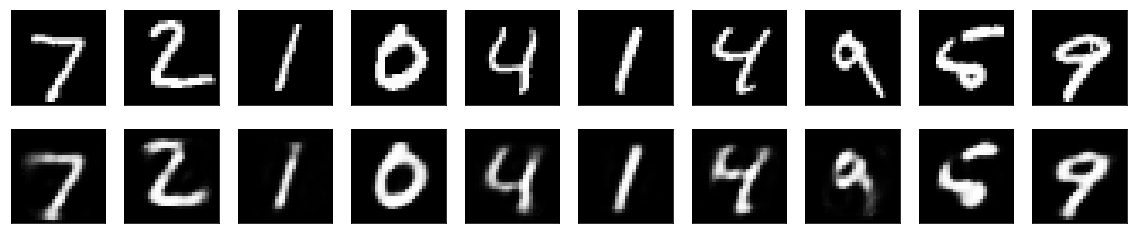

In [19]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()